# From batch to stream learning
---

notebooks adapted from the [streaming-data-analytics](https://github.com/emanueledellavalle/streaming-data-analytics) repo.

install requirements: `pip install -r requirements.txt`

---

Traditional machine learning follows a sequence of steps. A minimal pipeline includes:

1. Data preprocessing (cleanup, filtering, feature engineering, etc.)
2. Training (create a model from the data)
3. Testing (use the model to obtain predictions)

This approach assumes that **all** the data is available for training and data is processed in **batches**.

Let's see an example based on the [`Iris` dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) available in `scikit-learn`:

> This data set consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray

![iris example](../img/iris_example.png)

In [3]:
from sklearn import datasets as skdatasets
from sklearn.naive_bayes import GaussianNB as GaussianNBSKL   # Renamed to avoid name conflicts
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
sns.set(style="ticks", color_codes=True)

In [6]:
iris = skdatasets.load_iris()
x = iris.data
y = iris.target

In [7]:
print(x[0],y[0])

[5.1 3.5 1.4 0.2] 0


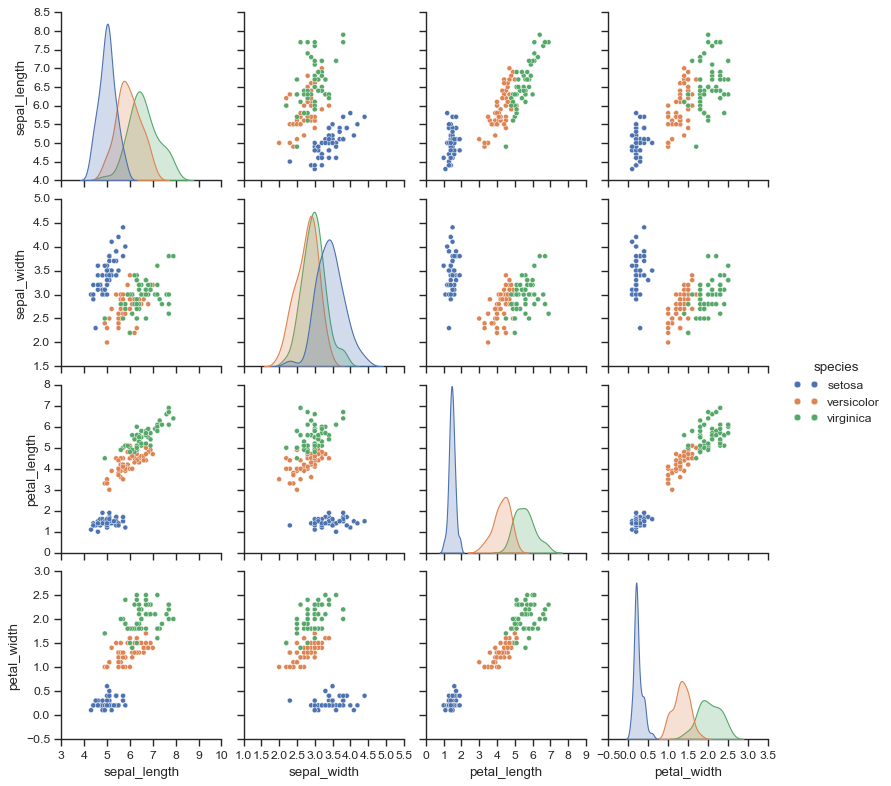

In [8]:
g = sns.pairplot(sns.load_dataset("iris"), hue="species")

The `load_iris()` returns the data set and related information. Data features and the corresponding targets (classification labels) are accessible via the `data` and `target` properties respectively.

We can assume that the data has been already preprocessed. We need to split the dataset into $train$ and $test$ sets where $train \notin test$. We can use the `train_test_split` method as follows:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.3, stratify=iris.target, random_state=42
)
print(f'Shape (n_rows, n_cols) of X: {iris.data.shape}, 'f'X_train: {X_train.shape}, X_test: {X_test.shape}')

Shape (n_rows, n_cols) of X: (150, 4), X_train: (105, 4), X_test: (45, 4)


# Offline Training

Now we proceed with the model training. In this example, we will train a Gaussian Naive Bayes model (`GaussianNB`).

In [10]:
model = GaussianNBSKL()
model.fit(X=X_train, y=y_train)

GaussianNB()

And we use the trained model to get predictions:

In [11]:
y_pred = model.predict(X=X_test)

`y_pred` contains the predicted class labels for each sample in `X_test`. Since we know the true labels for these samples (`y_test`) we can evaluate the performance of the model. In this case, we will use the `accuracy_score` method:

In [12]:
print(f'Model accuracy: {accuracy_score(y_test, y_pred):.4f}')

Model accuracy: 0.9111


The trained model has an accuracy of ~91%, which is decent considering the simplicity of the dataset.

As mentioned, batch methods expect **all the data** available for training. However, in multiple real-world applications, this requirement is difficult to meet, especially in dynamic environments that constantly generate data.

A common way to address this situation is to collect data over time and generate new models. However, this presents additional challenges:

- Should we train new models on new data only or extend the old data?
- How much new data is enough to trigger the creation of a new model?
- Is the new model better than the old one?
- Storing all data might be unfeasible or impractical in some cases (e.g. financial markets)
- ...

# Stream learning

A data stream is an infinite sequence of elements. Stream learning methods are specially designed to learn from data streams. Streaming models adhere to a set of requirements:

- **Process the data one sample at a time**. A sample is seen only once and it is gone after processing.
- **Be efficient**. Resources are limited (memory, time) but streams are infinite.
- **Predict at any time**. Models continually learn and provide predictions at any point in the stream.

A streaming model **updates** its internal state as it processes the data stream.

We can simulate a data stream from the previous example by "looping" over the data *one sample at a time* as follows:

In [13]:
for xi, yi in zip(X_train, y_train):
    # Here is where learning takes place
    pass

xi, yi    # last data sample

(array([4.6, 3.1, 1.5, 0.2]), 0)

Notice that the data is encoded in `numpy.ndarrays`, an efficient data structure when dealing with large 2D data.

In `river`, data is represented as `dict`. Dictionaries are fast to process 1D data and elements are easily accessible 'by key'.

Before using this data in `river` we must transform it. This is easily done in Python:

In [14]:
for xi, yi in zip(X_train, y_train):
    x = dict(zip(iris.feature_names, xi))

x, yi

({'sepal length (cm)': 4.6,
  'sepal width (cm)': 3.1,
  'petal length (cm)': 1.5,
  'petal width (cm)': 0.2},
 0)

In [15]:
import river
river.__version__

'0.21.0'

![River-logo](../img/river_logo.png)

[`River`](https://riverml.xyz/latest/) is a Python library for streaming (online) machine learning.


### Key features

- **Incremental learning** - All the tools in `river` can be updated with a single sample at a time.

- **Adaptive learning** - Adaptive methods are robust against concept drift in dynamic environments.

- **General-purpose** - `River` caters for different machine learning problems, including regression, classification, unsupervised learning, and ad-hoc tasks.

- **Efficient** - By design, streaming techniques efficiently handle resources such as memory and processing time, given the unbounded nature of data streams.

- **Easy to use** - `River` is intended for users with any experience level. As a machine learning package, it caters for practitioners as well as researchers.







In our previous example, we trained a Gaussian Naive Bayes model using the implementation from `scikit-learn`. The Naive Bayes method is an **incremental method**.

A small number of incremental methods are available in `scikit-learn` ([out-of-core methods](https://scikit-learn.org/stable/computing/scaling_strategies.html)). These methods provide a `partial_fit` method for incremental training using *mini-batches*.

In the following example, we will use the implementation of `GaussianNB` from `river`.

In `river`, training and predicting are perfomed via the `learn_one` and `predict_one` methods.

In [16]:
from river.naive_bayes import GaussianNB

model = GaussianNB()
for xi, yi in zip(X_train, y_train):
    x = dict(zip(iris.feature_names, xi))
    model.learn_one(x=x, y=yi)              # Train the model

y_pred = []
for xi in X_test:
    x = dict(zip(iris.feature_names, xi))
    y_pred.append(model.predict_one(x=x))   # Predict class-label

The model's predictions are in `y_pred`. Again, we measure the accuracy of the model by comparing predictions to the ground truth:

In [17]:
print(f'Model accuracy: {accuracy_score(y_test, y_pred):.4f}')

Model accuracy: 0.9111


Hurray! We got the same performance from the model trained one sample at a time...

But wait, this is NOT different from the "batch" setting. We are still doing "training" and then "testing" using two "for" loops.

In the streaming setting, training and predicting happen inside a single loop. Remember, a data sample is available only once in the stream.

To simplify our code, we can use the [iter_sklearn](https://riverml.xyz/latest/api/stream/iter-sklearn-dataset/) method to convert a `scikit-learn` dataset object into an iterable that returns the data as `dict`.

In [18]:
from river.stream import iter_sklearn_dataset

y_pred = []
y_true = []

model = GaussianNB()
for x, y in iter_sklearn_dataset(iris, shuffle=True, seed=42):
    y_p = model.predict_one(x)   # Predict class-label
    model.learn_one(x, y)        # Train the model
    if y_p is None:              # Process next sample if the model is empty
        continue
    y_pred.append(y_p)
    y_true.append(y)

print(f'Model accuracy: {accuracy_score(y_true, y_pred):.4f}')

Model accuracy: 0.9195


This time we have successfully implemented a stream learning task. This is known as **prequential evaluation** or **interleaved test-then-train** evaluation. 

Notice the *order* of the training and prediction operations. When a new data sample ($x_i$, $y_i$) arrives:

1. Predict the label ($y_i'$) for the new data sample ($x_i$), not "seen" by the model yet
2. Train the model using the new sample ($x_i$, $y_i$)

This **order matters**!

A benefit from this approach is that we can use *all* labeled samples in the stream to measure a model's performance. Notice that the model provides predictions at any point in the stream, depending on its current internal state. Batch methods can only predict after they finished training.

In the previous code snippet, we used two auxiliary variables to store the true labels and the predicted labels. This is because `accuracy_score` requires access to all the data. However, storing all the true and predicted labels from a data stream is *impractical*.

In `river`, all methods can be updated one single sample at a time, including performance metrics! Let's see how to update the [Accuracy](https://riverml.xyz/latest/api/metrics/Accuracy/) metric.

In [19]:
from river.metrics import Accuracy

metric = Accuracy()
for yt, yp in zip(y_true, y_pred):
    metric.update(y_true=yt, y_pred=yp)
metric

Accuracy: 91.95%

The `update` method takes true and predicted pairs and updates the metric. We can compare the confusion matrices:

In [20]:
print('Confusion matrix from all data:')
print(confusion_matrix(y_true, y_pred))
print('Confusion matrix from updatable metric:')
print(metric.cm)

Confusion matrix from all data:
[[48  1  0]
 [ 2 46  2]
 [ 0  7 43]]
Confusion matrix from updatable metric:
    0    1    2   
0   48    1    0  
1    2   46    2  
2    0    7   43  


Now we can rewrite our example.

In [21]:
model = GaussianNB()
metric = Accuracy()

for x, y in iter_sklearn_dataset(iris, shuffle=True, seed=42):
    y_p = model.predict_one(x)   # Predict class
    if y_p is not None:
        metric.update(y_true=y, y_pred=y_p)
    model.learn_one(x, y)        # Train the model

print(f'{len(y_pred)} samples analyzed.')   
print(metric)

149 samples analyzed.
Accuracy: 91.95%


### The `progressive_val_score` method

For convenience, the [progressive_val_score](https://riverml.xyz/latest/api/evaluate/progressive-val-score/) method implements the prequential evaluation. It requires three components: 

- a data stream
- a model
- a metric

In [22]:
from river.evaluate import progressive_val_score

# Setup stream and estimators
stream = iter_sklearn_dataset(iris, shuffle=True, seed=42)
nb = GaussianNB()
metric = Accuracy()

# Setup evaluator
progressive_val_score(dataset=stream, model=nb, metric=metric, print_every=10)

[10] Accuracy: 44.44%
[20] Accuracy: 73.68%
[30] Accuracy: 82.76%
[40] Accuracy: 84.62%
[50] Accuracy: 85.71%
[60] Accuracy: 88.14%
[70] Accuracy: 88.41%
[80] Accuracy: 89.87%
[90] Accuracy: 89.89%
[100] Accuracy: 90.91%
[110] Accuracy: 91.74%
[120] Accuracy: 92.44%
[130] Accuracy: 92.25%
[140] Accuracy: 92.81%
[150] Accuracy: 91.95%


Accuracy: 91.95%

# Exercises
Some interesting modifications that you can try to 
- implement a window or discount factor in the prequential accuracy (you can also try to use the Metric interface to make it more easily reusable). Plot the learning curve to see how the metric is changing over time as the model learns from more data.
- compare the prequential accuracy against an holdout accuracy.
- compare the time or memory occupation of an ML model and its streaming version. Linear models, Naive Bayes, decision trees are all available on scikit-learn (batch) and river (stream).